https://medium.com/@srijith.rajamohan/using-bayesian-hierarchical-models-in-pymc3-to-infer-the-disease-parameters-of-covid-19-b396c8b9845
https://databricks.com/blog/2021/01/06/bayesian-modeling-of-the-temporal-dynamics-of-covid-19-using-pymc3.html
https://sjster.github.io/introduction_to_computational_statistics/docs/Production/Covid_modeling.html


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.figure_factory as ff
import scipy.stats
import pymc3 as pm
import arviz as az
import sunode
import sunode.wrappers.as_theano
from pymc3.ode import DifferentialEquation
import theano.tensor as tt
import datetime
import shelve
from datetime import datetime as dt
import time

Poosible replacement if I prefer to use data from Brazilian cities on the hierarchical model

In [63]:
#pd.read_csv("https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv", date_parser=True).dtypes

In [62]:
class COVID_data():
     
    def __init__(self, country='Brazil', Population = 212.6e6):
 
        confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
        self.confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
        deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
        self.deaths = pd.read_csv(deaths_url, sep=',')
        self.country = country
        self.N = Population   # Population of the country - you need to define the s0 at t0 on ode IVP problemns
 
    def get_dates(self, data_begin='7/11/20', data_end='7/20/20'):
 
        # ------------------------- Date for inference ----------------------#
        self.data_begin = data_begin 
        self.data_end = data_end
        confirmed_cases = self.confirmed_cases
        country = self.country
        self.cases_obs = np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == country, data_begin:data_end])[0]
 
        print(f"------------ COVID Data for {country}, from {data_begin} to {data_end}, Loaded ----------- ")

1. Modularizar ao máximo o código
    - Inclusive separando a o model do run caso seja possível vizualizar o diagrama do modelo -> TENTAR
2. Montar código básico para modelo hierarquico (aka incluindo +1 país)
    - Refletir se quero isto direto ou já crio notebook com dados sintéticos
3. Criar ambiente funcional de MLFlow

In [65]:
class SIR_model_sunode():
 
    def __init__(self, covid_data) :
 
        # ------------------------- Covid_data object -----------------------#
        self.covid_data = covid_data
        # ------------------------- Setup SIR model, but has to be called explicitly to run ------------------------#
        self.setup_SIR_model()
 
    def SIR_sunode_rhs_ode(self, t, y, p):
        return {
            'S': -p.lam * y.S * y.I,
            'I': p.lam * y.S * y.I - p.mu * y.I,
        }
 
    def setup_SIR_model(self):
        self.time_range = np.arange(0,len(self.covid_data.cases_obs),1)
        self.I0 = self.covid_data.cases_obs[0]
        self.S0 = self.covid_data.N - self.I0
        self.S_init = self.S0 / self.covid_data.N
        self.I_init = self.I0 / self.covid_data.N
        self.cases_obs_scaled = self.covid_data.cases_obs / self.covid_data.N
 
 
    def run_SIR_model(self, n_samples, n_tune, likelihood, prior):
        # ------------------------- Metadata --------------------------------#
        self.likelihood = likelihood
        self.n_samples = n_samples
        self.n_tune = n_tune
        self.likelihood = likelihood
        self.prior = prior
        
        ## posteroily, I'll add those on MLFlow XP
        #t = time.time()
 
        with pm.Model() as model4:
            ## pymc RVs - Priors
            sigma = pm.HalfCauchy('sigma', self.likelihood['sigma'], shape=1)
            lam = pm.Lognormal('lambda', self.prior['lam'], self.prior['lambda_std']) # 1.5, 1.5
            mu = pm.Lognormal('mu', self.prior['mu'], self.prior['mu_std'])           # 1.5, 1.5
            ## sunode ODE equation and gradients computed using sunode
            res, _, problem, solver, _, _ = sunode.wrappers.as_theano.solve_ivp(
                y0={'S': (self.S_init, ()), 'I': (self.I_init, ()),},
                params={'lam': (lam, ()), 'mu': (mu, ()), '_dummy': (np.array(1.), ())},
                rhs=self.SIR_sunode_rhs_ode,
                tvals=self.time_range,
                t0=self.time_range[0]
            )
            ## pymc RVs - likelihood
            if(likelihood['distribution'] == 'lognormal'):
                I = pm.Lognormal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'normal'):
                I = pm.Normal('I', mu=res['I'], sigma=sigma, observed=self.cases_obs_scaled)
            elif(likelihood['distribution'] == 'students-t'):
                I = pm.StudentT( "I",  nu=likelihood['nu'],       # likelihood distribution of the data
                        mu=res['I'],     # likelihood distribution mean, these are the predictions from SIR
                        sigma=sigma,
                        observed=self.cases_obs_scaled
                        )
            R0 = pm.Deterministic('R0',lam/mu)
            
            ## pymc posteriori sampling
            trace = pm.sample(self.n_samples, tune=self.n_tune, 
                              chains=4, cores=4) #mp_ctx="forkserver", pickle_backend='dill' - opt args
            
            data = az.from_pymc3(trace=trace)
 
        #t1 = time.time() - t
        ## viz
        az.plot_posterior(data, round_to=2, point_estimate='mode', hdi_prob=0.95)
        axes = az.plot_trace(trace)
        fig = axes.ravel()[0].figure
        #fig.savefig(self.filename)
        
        fig = ff.create_distplot([trace['R0']], bin_size=0.5, group_labels=['x'])
 
        # Add title
        fig.update_layout(title_text='Curve and Rug Plot')
        fig.update_xaxes(range=[0,7])
              
        ## posteroily, I'll add those on MLFlow XP
        #self.metadata_db = shelve.open(metadata_db_filename)
        #self.metadata_db[self.filename] = {'type': 'sir', 'samples': n_samples,
        #                            'tune': n_tune,
        #                            'elapsed_time': t1,
        #                            'finished': dt.now().strftime("%d-%m-%Y_%H:%M:%S"),
        #                            'likelihood': likelihood,
        #                            'prior': prior }
        #self.metadata_db.close()
        return(fig)
 
 
 

------------ COVID Data for Brazil, from 3/1/20 to 9/28/20, Loaded ----------- 


/tmp/ipykernel_42/3674019317.py:63: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(self.n_samples, tune=self.n_tune,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, lambda, sigma]



[CVODES ERROR]  CVode
  At t = 0.0127851, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.202168, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.158608, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.112444, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00964146, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.199256, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.178374, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.268877, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0531245, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.119708, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.267671, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0454517, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.215477, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.219301, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.229576, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.236956, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.248916, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.269693, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.0871341, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.193473, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0121342, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.153209, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0042746, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.183818, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.208072, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.229204, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0248881, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.221798, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.223192, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.240515, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.155516, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.128503, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.244695, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.249168, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00316514, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.228675, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.227759, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.134723, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.222032, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.160821, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.425665, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.190745, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.18841, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.220922, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.2226, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.207886, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.211196, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.221911, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CV


[CVODES ERROR]  CVode
  At t = 0.224198, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.165821, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.165721, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.225012, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.223981, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.21079, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.206856, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.149296, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.247193, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0862454, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00884932, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.259253, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.220993, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.203416, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.217108, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.224289, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.222061, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.209435, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.185609, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00229174, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.224972, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.177442, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.216301, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.248742, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.238589, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0199343, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.169733, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.227659, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0148585, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.136261, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.208712, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.153264, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.190414, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.204587, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.20993, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.229451, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.241017, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0146032, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.193311, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0877928, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.249735, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.191008, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.215661, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0903882, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.178242, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.211671, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.188275, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.211459, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.257391, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.025771, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.133426, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.109719, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.249468, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00295887, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.0657406, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.211517, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.182818, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.181478, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.171593, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.147681, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.217234, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0964542, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.172473, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.193017, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.188655, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.146434, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.144625, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.14291, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.109435, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.165045, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.225309, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.199221, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.164582, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.125298, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0624625, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.129594, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0653477, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00654167, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERR


[CVODES ERROR]  CVode
  At t = 0.0555441, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.18224, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.201731, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.211335, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.208124, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.18929, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.0712481, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.280295, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0380944, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.255282, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0336386, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.267206, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.227305, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.106581, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.125497, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.237229, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.104376, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.221717, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.175515, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.16678, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0993713, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.198013, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.264695, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0993713, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.0981534, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.167824, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.22064, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.238223, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.169788, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.18824, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.253718, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0311619, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.250984, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0267704, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.26196, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0278736, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.231401, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.233226, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.128113, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.253436, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0346272, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.220621, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.205992, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00775125, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.206788, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.170195, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.214147, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0120742, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.255652, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.228693, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.262452, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.157991, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0724976, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0077081, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.158553, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.133515, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.185438, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.176676, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00326447, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0449567, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.224446, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.254339, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0413681, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.268854, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0267913, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.100105, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.249319, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.277008, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.270643, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0444368, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.223799, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.243738, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.241881, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.221281, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.223304, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.156389, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.219846, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.223304, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.22767, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.205885, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.227881, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.225036, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.271525, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.218158, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.266289, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0606013, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.165354, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0785782, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode

[CVODES ERROR]  CVode
  At t = 0.14063, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0

  At t = 0.223931, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.083895, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0425271, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0772374, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.126526, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.124411, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.114789, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.26095, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.102571, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.238213, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.111526, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.1686, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.159593, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CV


[CVODES ERROR]  CVode
  At t = 0.12936, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.147773, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.229923, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.1519, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.212633, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.159493, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CV


[CVODES ERROR]  CVode
  At t = 0.165497, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0977989, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0831996, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0883308, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.174747, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0841336, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERR


[CVODES ERROR]  CVode
  At t = 0.0936463, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0976056, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0750945, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0936463, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.103875, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.159311, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERR


[CVODES ERROR]  CVode
  At t = 0.210552, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.219719, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.205201, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.135045, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.249075, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.257113, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.211396, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0348173, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.231291, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.185253, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.104035, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.220101, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.216553, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.239182, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.163895, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.22473, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0802736, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.140495, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.00258813, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00759448, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.18005, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.280667, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0932131, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.176462, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERR


[CVODES ERROR]  CVode
  At t = 0.174402, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.101915, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.159451, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0623994, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.154737, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.111966, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.148999, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.246378, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.210494, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0482962, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.100265, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.139911, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.238726, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.106075, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.231246, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.255919, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0349287, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0554128, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.218242, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.218361, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.21149, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.280384, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.170234, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0657034, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.171677, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.241221, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.205878, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0736538, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00754129, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.15382, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.0113361, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.245695, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0271894, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode

[CVODES ERROR]  CVode
  At t = 0.220354, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0

  At t = 0.211246, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.167408, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.110631, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.205348, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.273396, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.234154, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.217251, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.142744, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.222468, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0981082, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.200452, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0505187, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.200452, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0964638, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.180365, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.106715, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.161377, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.219151, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.273688, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.239426, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.0960465, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.215622, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0721252, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.198877, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.191361, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.198877, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.0148786, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0870282, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.142677, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0185457, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.14023, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.210287, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.174206, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.139206, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.184314, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.139206, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.121868, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.174206, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.232275, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.113923, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.233224, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.232275, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.255502, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.194088, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.265546, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.130927, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0123793, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.195333, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.297381, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.178627, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.226266, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00997418, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.233473, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.252811, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0230002, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.154624, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.246085, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0407074, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0961555, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.140163, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0407074, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.263633, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.164501, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.138917, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.216689, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.156599, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.210178, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0209851, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.0125734, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0943312, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.260817, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0255618, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0943312, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.227804, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERR


[CVODES ERROR]  CVode
  At t = 0.180468, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.215554, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.229537, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.132398, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.153165, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.165062, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.156189, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.21566, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.160851, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0482271, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.291949, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00129192, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.11278, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.221463, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.233122, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.234099, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.11278, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.230225, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  C


[CVODES ERROR]  CVode
  At t = 0.0220779, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.247116, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.213586, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.019766, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.185079, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.215033, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.181749, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.114911, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.161037, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.146933, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0595411, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.223654, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.00232271, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.22039, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.178029, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.209056, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.146267, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.209056, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.177234, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.10617, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.205508, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0101566, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.154141, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.213605, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.178309, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.158586, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0843148, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.214361, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0843148, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.218044, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.249892, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00378616, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.204384, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.180958, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.272004, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.164275, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.135327, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.262127, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.210807, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.268836, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0346115, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.293055, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.161078, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.224178, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.208136, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0177373, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.197562, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00899359, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.209892, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.156017, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.178897, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.224194, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0271323, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.237586, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.252433, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.228916, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0690408, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.191168, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.146832, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0690408, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.290902, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.242869, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.21675, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.164291, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.172922, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.197795, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.0752697, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0752697, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.267243, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0752697, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.184393, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.25762, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.0462006, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.204115, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0890876, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.134548, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.22864, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.150784, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.275377, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0349711, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.216236, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.18624, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.2151, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.269357, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  C


[CVODES ERROR]  CVode
  At t = 0.11817, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.1103, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.162481, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.169518, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.210163, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.168536, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CV


[CVODES ERROR]  CVode
  At t = 0.00694327, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.219451, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.237841, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0226097, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.168505, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0937054, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERR


[CVODES ERROR]  CVode
  At t = 0.196815, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0139066, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.1687, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.174961, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.117465, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.130608, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.160697, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.25145, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.030561, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.214894, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.170233, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.279322, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.210183, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.221605, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.110266, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.205649, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.210489, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.110266, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.238546, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00287227, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.22148, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.101875, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.144032, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.22148, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.232419, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.270129, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.226124, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0116905, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.208606, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.175025, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.132498, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.280778, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.273198, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0419343, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.273198, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0419343, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.271848, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.198939, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.165298, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.165298, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.154015, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.203745, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.173541, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.13339, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.21464, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.197734, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.277972, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00238599, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.168184, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.17435, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.17435, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.280664, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0432076, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.21256, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  C


[CVODES ERROR]  CVode
  At t = 0.228066, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.206866, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.222581, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.255596, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0388291, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.192639, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.235831, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0114363, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.206826, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.223806, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.109088, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.145871, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.220311, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.225673, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.237954, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.028613, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.225673, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.236787, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.26023, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0367737, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.258196, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0364806, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.26023, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0367737, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.20355, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.198031, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.163727, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.173969, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.24496, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.24496, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CV


[CVODES ERROR]  CVode
  At t = 0.136976, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.190743, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.204568, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0199974, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.12058, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.179129, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.148048, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.272707, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0341335, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.232009, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.170873, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.117803, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.142267, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.272445, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0286934, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.272445, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0286934, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.242943, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.246766, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.166095, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.254094, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0337015, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.1619, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.211937, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.212346, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0146853, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.27115, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.212729, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.119067, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.155668, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.16383, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.146203, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0061602, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.153689, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.213927, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.153689, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.266056, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0252839, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.269275, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.232619, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.156814, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.255189, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.109325, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.219271, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.180862, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.240476, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.11359, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.11359, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  C


[CVODES ERROR]  CVode
  At t = 0.201622, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.122229, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.22647, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.134166, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.236216, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.141262, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.230163, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0115025, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.24394, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.230958, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0105197, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.103832, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.134353, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.22106, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.257361, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.19906, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.223141, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.032677, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  C


[CVODES ERROR]  CVode
  At t = 0.241468, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.258577, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.258577, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.238482, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0229735, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.166855, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.207863, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.018111, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.207863, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.172139, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.188325, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.176159, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.166472, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.261866, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0216742, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.164471, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.205451, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.164471, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.165407, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.118811, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.203435, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.213132, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.213132, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODEA ERROR]  CVodeF
  At t = 0.999221, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  At t = 0.999221, mxstep steps taken before reaching tout.


[CVODES E


[CVODES ERROR]  CVode
  At t = 0.305114, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.064952, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.12915, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0762762, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.238724, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.230547, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.234621, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0601518, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00324382, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.212273, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.244936, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0352066, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERR


[CVODES ERROR]  CVode
  At t = 0.123106, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00599833, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.232537, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00599833, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.260869, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0306101, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ER


[CVODES ERROR]  CVode
  At t = 0.222383, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0765299, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.198828, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.227716, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0294786, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.249377, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.154706, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.210518, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.191732, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.231084, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.151949, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.219488, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.224062, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.165207, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.165207, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.193054, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0094976, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.213904, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.207936, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.264143, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0744676, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.222941, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0247295, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0744676, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.173316, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.173712, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.230713, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0209617, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.227442, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.02633, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.139626, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.138004, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.139626, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00969197, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.202463, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00969197, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERR


[CVODES ERROR]  CVode
  At t = 0.188587, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.101624, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.20964, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.2397, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.20964, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.20329, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVod


[CVODES ERROR]  CVode
  At t = 0.193773, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.122897, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.240822, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00107069, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.113343, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.136663, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.209321, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.172396, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.209321, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.23275, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.212119, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.23275, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  C


[CVODES ERROR]  CVode
  At t = 0.23209, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0668321, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.180012, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.156372, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.156372, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.114973, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.197984, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.217233, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.174483, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.168904, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.163255, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.174483, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.206883, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.231483, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.224419, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.173567, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00808857, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00808857, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERR


[CVODES ERROR]  CVode
  At t = 0.17405, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00086318, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.209082, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0156221, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0173625, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.144804, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.254075, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.176414, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.254075, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.176414, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.022682, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.022682, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.156833, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.175678, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.175678, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.167051, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.144551, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.144551, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.136106, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.226914, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.206818, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0131471, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0131471, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.224829, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.16022, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.20849, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0116889, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.217265, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.24937, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00957305, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.238752, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0941878, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.275594, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0540828, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.212885, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.173642, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.253646, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00252236, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.269945, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0350503, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.242801, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.106297, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.183167, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.215179, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.183167, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.214366, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.284271, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.284271, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.127607, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.250261, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.036242, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.181318, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.149752, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.239702, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.0225803, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.134759, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.200225, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.240644, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.121784, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.237145, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.203137, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.219152, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.192646, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0250831, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.151092, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00406757, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.113154, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.207746, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.122724, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.122724, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.202335, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.118351, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.123842, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.184756, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.118966, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.17445, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.222161, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.178915, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.0709043, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.218508, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.211103, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0210404, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.147449, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.218213, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.172585, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0601175, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.1792, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.156938, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.216236, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0881009, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.119157, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0997042, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.119157, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.227946, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.247391, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.204162, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.261377, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0368275, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.218304, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.223203, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.219384, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.226826, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.212614, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0109226, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.264802, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.229861, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.229861, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.202514, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.198029, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.220587, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.113819, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.220587, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.113819, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.171343, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.204459, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.176042, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0121305, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.204459, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0121305, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.186449, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.087937, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.212848, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.272777, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0359442, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.082848, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0766505, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.000983457, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0481258, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0846687, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.197694, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.10899, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0846687, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ER


[CVODES ERROR]  CVode
  At t = 0.217701, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.153573, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.130539, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.153573, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.28717, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0370092, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.210309, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.166294, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.166294, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.140868, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.185606, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.127769, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.138276, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.223418, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.214081, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.223418, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.245643, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.245643, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.289805, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.115342, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.196485, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00914944, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.256672, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00248658, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERR


[CVODES ERROR]  CVode
  At t = 0.258249, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.168093, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.122114, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.214562, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.169074, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00149476, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.0313173, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.116319, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.161707, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.225046, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0193298, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.116319, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.155638, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0645558, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.268974, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0248397, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.205188, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.260427, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.103001, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.283251, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.283251, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.114258, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.228079, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.236885, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.215221, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.234218, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.207494, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0859396, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.152456, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.235403, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.202218, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.256199, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0464889, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.216242, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.256199, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0464889, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.261287, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0438918, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.250984, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0279782, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.187718, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.153318, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.228678, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0356196, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.19031, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.122028, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.193249, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.222711, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.120177, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.154625, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0563476, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.25671, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.215639, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.168747, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.198271, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0799969, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.241522, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0304602, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.24509, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0234566, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.198839, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.198839, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0399246, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0127432, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.219364, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00438442, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERR


[CVODES ERROR]  CVode
  At t = 0.186546, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.156744, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0412477, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.186723, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.186723, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.171575, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.0394954, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.238078, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.24442, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.065235, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.182535, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.065235, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.188464, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0132599, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.242373, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.204252, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.271274, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.204252, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.239045, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.139302, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.188331, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.23005, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.14318, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.180644, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  C


[CVODES ERROR]  CVode
  At t = 0.227865, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0160581, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.210977, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.215522, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0154992, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.215522, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.272472, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0335912, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.241234, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0713949, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.225161, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0713949, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.205571, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.251052, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.251052, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.140861, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.074419, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.074419, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.256103, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0392232, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.225959, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0156446, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0342944, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.273739, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.152504, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0949929, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.147719, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.209077, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.169719, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.266607, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.214089, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0303162, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.257036, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0163912, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.221641, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.280085, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.17999, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000226739, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.119595, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.211152, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.217888, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.220828, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.164993, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.184976, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.237015, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.155812, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.129963, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.155812, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.147226, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.287541, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.246604, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.174879, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.165355, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.214604, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.125022, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.213294, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0137924, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.171505, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.213294, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.143529, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.155394, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.124325, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.181572, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.162545, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.247636, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0298011, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.219057, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.15342, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.205276, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.205276, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.131171, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.207767, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.133213, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.219017, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.225433, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.191533, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.225433, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.11764, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.21634, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.116623, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0391941, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.23741, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.177797, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0409105, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.00964305, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.207203, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0222771, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.124934, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.124576, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.11439, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.0640399, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.174886, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.146376, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.146376, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.208388, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0783742, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.21711, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.130237, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.142725, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.127321, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.142725, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0714334, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.261666, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0439254, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.292794, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.231844, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.001264, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.228334, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.188468, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.12333, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.12333, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0805187, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.169081, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.261377, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.189181, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.008679, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.277495, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0452608, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.008679, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.231171, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.235057, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00647435, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.13775, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.13775, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.154916, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.142582, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.220984, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.22599, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.220886, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0215166, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.220984, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.259633, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.074806, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.224054, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.074806, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.101042, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.12802, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.142038, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.205388, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00732205, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.263096, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0197601, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.263096, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0197601, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERR


[CVODES ERROR]  CVode
  At t = 0.248768, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.154644, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.196931, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.196931, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.111509, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.120811, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.194864, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00256264, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.186203, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.207012, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0866912, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.276436, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.216101, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.100723, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.285615, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0557693, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.216101, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.257709, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.259931, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00969522, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0210546, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.241237, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.166138, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00969522, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ER


[CVODES ERROR]  CVode
  At t = 0.205601, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0168642, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.236011, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.216186, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.100157, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.24269, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.189745, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.253531, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.174692, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.120501, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.189745, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.148083, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.0502901, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0121966, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.16696, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.146282, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.238311, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0278125, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.215574, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.054262, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.113672, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.123611, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.123611, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0871049, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.249203, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0256613, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.017105, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.134532, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.208389, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.17893, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.222768, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.212907, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0127151, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.115666, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.135026, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.243656, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.161438, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0114477, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.20667, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.20667, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.16115, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.239594, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  C


[CVODES ERROR]  CVode
  At t = 0.281806, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.137805, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.210714, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.210714, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.209, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.194453, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CV


[CVODES ERROR]  CVode
  At t = 0.259854, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0329585, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.259854, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0329585, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.274073, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0362697, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.275089, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0479956, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.217584, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.150826, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.204764, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.200177, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.215551, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.215551, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.100548, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.168924, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.215551, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.217679, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.277927, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.217138, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.236881, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.219688, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.199878, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.23895, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.255826, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0283273, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0914974, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.14866, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0914974, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0401848, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.200395, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00850547, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.210817, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0109416, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.232013, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0269529, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERR


[CVODES ERROR]  CVode
  At t = 0.191804, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.191804, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.161279, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0355374, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.214111, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0355374, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.228497, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00142959, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.235574, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0782409, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0803919, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0782409, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ER


[CVODES ERROR]  CVode
  At t = 0.254026, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.193082, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.115766, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.1494, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.202295, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.213466, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  C


[CVODES ERROR]  CVode
  At t = 0.191793, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.16988, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.109126, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.16988, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0651054, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0238891, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.183782, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.101329, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.18183, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.18183, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.165138, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.232788, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  C


[CVODES ERROR]  CVode
  At t = 0.186116, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.186116, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.164886, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.213112, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0190085, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.164886, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.0943962, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00773005, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.248271, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00222681, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00773005, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.191927, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES 


[CVODES ERROR]  CVode
  At t = 0.245064, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.022672, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.188364, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.212979, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0127483, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.11677, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.144175, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.144175, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.142312, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.152119, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.268115, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0438165, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.0593635, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.200876, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0593635, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.170782, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.170782, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.274469, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.239692, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0218072, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.179605, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00815558, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0106764, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.12586, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.274652, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.046241, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.219303, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00531734, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.133626, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.238831, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.0843114, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.220317, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.111268, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.111268, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0984884, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.219107, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.241658, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.185338, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.250668, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0290176, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.266742, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.119016, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.267494, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0357658, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.17588, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00770708, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.184234, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0970966, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.231589, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.194204, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.228847, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.023323, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.136884, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000486155, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.259696, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.206111, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.190253, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.182834, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.190253, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.21852, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.233795, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0117309, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.169372, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.184136, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00888189, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.145102, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.119489, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.190028, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.119489, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0110751, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.192721, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0148971, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR


[CVODES ERROR]  CVode
  At t = 0.225564, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0476242, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.247431, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0371121, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.239787, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0197604, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.09756, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.146531, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.134837, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.146531, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.143142, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.272798, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.120757, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.156278, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.2813, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0489607, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.210831, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.140852, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.0821252, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.180885, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.180885, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.262154, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.156035, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.166038, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.281591, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0306179, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.178551, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.258613, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.025362, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.178551, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.378259, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0437659, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.378259, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0437659, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.232768, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0987159, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.193706, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.220025, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.193706, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.138674, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.178023, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000439919, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERRO


[CVODES ERROR]  CVode
  At t = 0.157912, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.157912, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.165595, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.130708, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.147353, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.130708, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.203758, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.125204, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.203758, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.223897, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.108118, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.223897, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.191995, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.230607, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0112551, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.230607, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.158626, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.186999, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.226593, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.15165, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.212082, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.223402, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.15165, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.212082, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  C


[CVODES ERROR]  CVode
  At t = 0.224326, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.184177, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0990898, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.141858, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.214067, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.241141, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.139167, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.213817, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.28535, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00894286, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0865149, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.22784, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]


[CVODES ERROR]  CVode
  At t = 0.126799, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.185797, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.160187, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.12652, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.126799, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.236786, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  


[CVODES ERROR]  CVode
  At t = 0.207305, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0534389, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.171419, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.200401, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.249242, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.11483, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 


[CVODES ERROR]  CVode
  At t = 0.178646, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.269659, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.269659, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.223473, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.228132, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.228132, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR] 

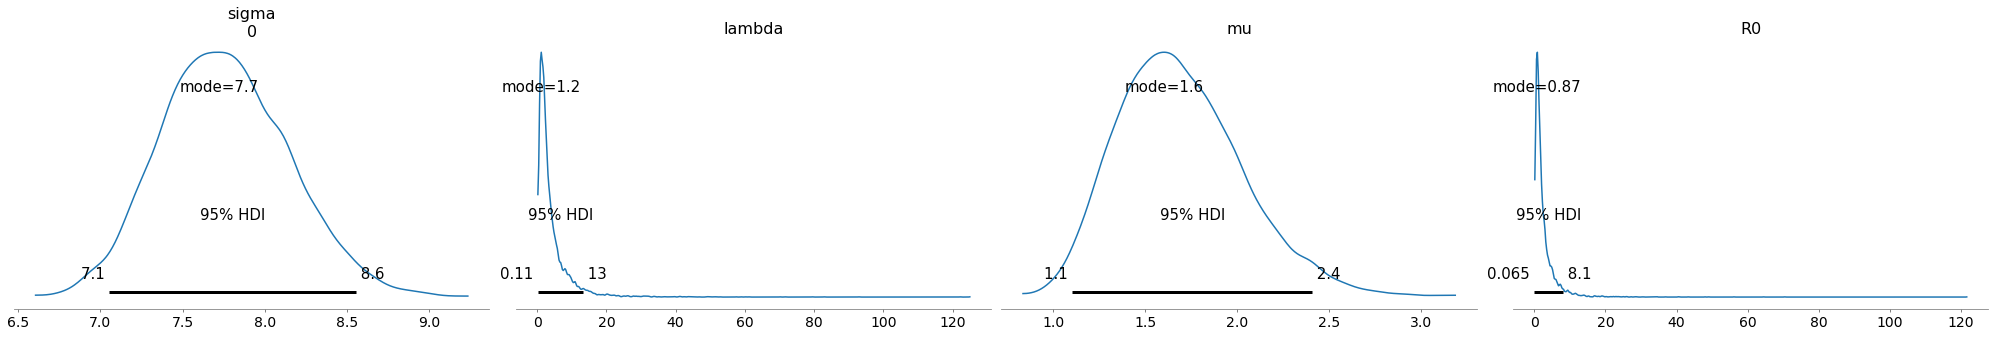

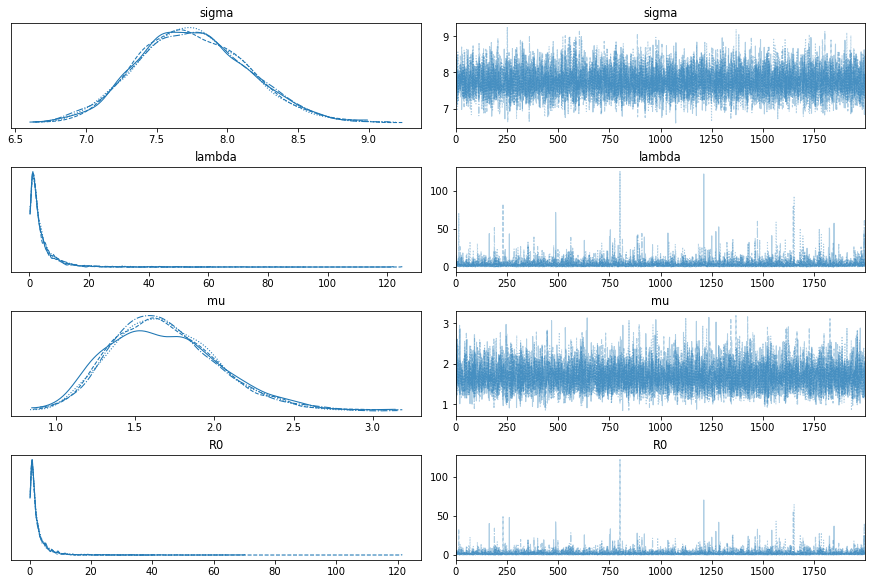

In [68]:
# -------- Usage --------#
covid_obj = COVID_data()
covid_obj.get_dates(data_begin='3/1/20', data_end='9/28/20')
sir_model = SIR_model_sunode(covid_obj)
likelihood = {'distribution': 'lognormal', 
              'sigma': 2}
prior = {'lam': 1.0, 
         'mu': 0.5, 
         'lambda_std': 1.0,
         'mu_std': 0.2 }
fig1 = sir_model.run_SIR_model(n_samples=2000, n_tune=1000, likelihood=likelihood, prior=prior)